#### Objective: 

**Build a machine learning model to classify news articles as Fake (1) or Real (0).**

The advancement in technology - which enables fast spread of information, and the rampant increase in fake news is a big challenge for many people due to the inability to differentiate fake and real news. This project aims to build an LSTM classifier that will help platforms detect fake news before spreading out to the public. 

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the train data
df = pd.read_csv("fake_news_train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# Basic exploration
print(df.info())     # data contains 5 features with 20,799 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None


In [5]:
print(df[df['label'] == 1].sample(3)['title'])
print(df[df['label'] == 0].sample(3)['title'])

877                                       WWN’s Horoscopes
12376    Mainstream Media Calls Real News “Fake” Becaus...
555                                                    NaN
Name: title, dtype: object
3352     Review: ‘Café Society’ Isn’t Woody Allen’s Wor...
20025    Emmy Nominations 2016: ‘Game of Thrones’ Rules...
14717    Whitney Houston, Cher, Tina Turner and Donna S...
Name: title, dtype: object


In [6]:
# Missing values
features_with_na = [feature for feature in df.columns if df[feature].isnull().sum()>1]

for feature in features_with_na:
    print(feature, ":", np.round(df[feature].isnull().mean(), 4) * 100, "% missing values")

# Three features contain missing values: title, author, and text

title : 2.68 % missing values
author : 9.41 % missing values
text : 0.19 % missing values


    Since we are working on text data, and we aim to use title to predict whether news is fake or real, we can't replace the missing values, thus we drop them.

In [7]:
# Drop nan values
df = df.dropna()

In [8]:
# Reset the index
messages = df.copy()
messages.reset_index(inplace=True)

In [8]:
messages.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [11]:
# Get independent features
X = df.drop("label", axis=1)

In [9]:
# Dependent feature
y = df["label"]

In [12]:
print(X.shape)
print(y.shape)

(18285, 4)
(18285,)


In [13]:
# Data Preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
corpus = []

for i in range(0, len(messages)):
    title = re.sub("[^a-zA-Z]", " ", messages["title"][i])
    title = title.lower()
    title = re.sub(r'http\S+|www\S+|https\S+', '', title)     # Remove punctuation
    title = re.sub(r'http\S+|www\S+|https\S+', '', title)        # Remove URLs
    title = re.sub(r'@\w+|#\w+', '', title)       # Remove mentions and hashtags
    title = re.sub(r'\d+', '', title)           # Remove numbers
    title = re.sub(r'\s+', ' ', title).strip()     # Remove extra whitespace
    tokens = word_tokenize(title)
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    cleaned_text = " ".join(tokens)
    corpus.append(cleaned_text)

In [15]:
corpus[:5]

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified',
 'iranian woman jailed fictional unpublished story woman stoned death adultery']

**Count Word Frequencies - Helps to identify the most common words**

In [16]:
from collections import Counter

# Tokenize all words in corpus
all_words = ' '.join(corpus).split()
word_freq = Counter(all_words)
print(word_freq.most_common(10))

[('new', 7024), ('time', 6478), ('york', 6342), ('trump', 3493), ('breitbart', 2402), ('hillary', 1123), ('clinton', 1120), ('u', 993), ('donald', 840), ('election', 584)]


**Distribution of word count per sentence**

In [17]:
# Count number of words per sentence
word_counts = [len(sentence.split()) for sentence in corpus]
print(word_counts[:5])

[10, 7, 4, 6, 10]


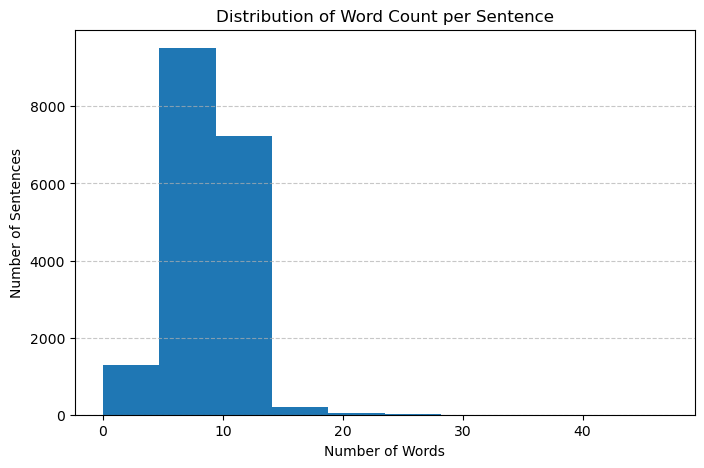

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
plt.hist(word_counts)
plt.title('Distribution of Word Count per Sentence')
plt.xlabel('Number of Words')
plt.ylabel('Number of Sentences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

    Above histogram shows that majority of the titles have a length between 5-15 words. With only a few words extending beyond 20

In [ ]:
# Import tensorflow
import tensorflow as tf
print(tf.__version__)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.regularizers import l2

In [24]:
# Define the vocabulary size, maximum sentence length, and word dimension
vocab_size = 5000
sent_length = 20
feature_dim = 32  

In [22]:
# Apply one hot representation on the corpus
one_hot_repr = [one_hot(sentence, vocab_size) for sentence in corpus]

In [23]:
one_hot_repr[:5]

[[2445, 3112, 1931, 1070, 3710, 993, 3273, 4543, 2528, 2420],
 [2973, 279, 3289, 1814, 1952, 3335, 1714],
 [1266, 92, 2678, 3930],
 [1420, 2954, 1346, 2249, 3767, 2004],
 [795, 1952, 3627, 2266, 3744, 2248, 1952, 2935, 3133, 2357]]

In [25]:
# Embedding Representation - First apply padding to ensure sentence uniformity
embedded_docs = pad_sequences(one_hot_repr, padding="pre", maxlen=sent_length)
embedded_docs[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2445,
        3112, 1931, 1070, 3710,  993, 3273, 4543, 2528, 2420],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 2973,  279, 3289, 1814, 1952, 3335, 1714],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1266,   92, 2678, 3930],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1420, 2954, 1346, 2249, 3767, 2004],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  795,
        1952, 3627, 2266, 3744, 2248, 1952, 2935, 3133, 2357]])

In [26]:
X_final = np.array(embedded_docs) 
y_final = np.array(y)

In [27]:
# Function to create the LSTM model
def lstm_model():
    model = Sequential()
    
    # 1st layer
    model.add(Embedding(vocab_size, feature_dim, input_length=sent_length)) 
    model.add(LSTM(64, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), return_sequences=True))
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(LSTM(32, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile model
    model.compile(loss="binary_crossentropy", 
                  optimizer="adam", 
                  metrics=["accuracy"])
    
    return model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [29]:
# Create model
model = lstm_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 20, 64)            24832     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 197,281
Trainable params: 197,281
Non-trai

In [30]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [31]:
# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20,  
                    batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 22s 63ms/step - loss: 0.4713 - accuracy: 0.8123 - val_loss: 0.2600 - val_accuracy: 0.9141
Epoch 2/20
200/200 [==============================] - 11s 53ms/step - loss: 0.1957 - accuracy: 0.9391 - val_loss: 0.2323 - val_accuracy: 0.9167
Epoch 3/20
200/200 [==============================] - 13s 63ms/step - loss: 0.1423 - accuracy: 0.9610 - val_loss: 0.2448 - val_accuracy: 0.9129
Epoch 4/20
200/200 [==============================] - 13s 65ms/step - loss: 0.1054 - accuracy: 0.9725 - val_loss: 0.3083 - val_accuracy: 0.9123
Epoch 5/20
200/200 [==============================] - 13s 66ms/step - loss: 0.0825 - accuracy: 0.9802 - val_loss: 0.2975 - val_accuracy: 0.9100
Epoch 5: early stopping


In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

172/172 [==============================] - 3s 17ms/step - loss: 0.2323 - accuracy: 0.9167
Test Loss: 0.2323
Test Accuracy: 0.9167


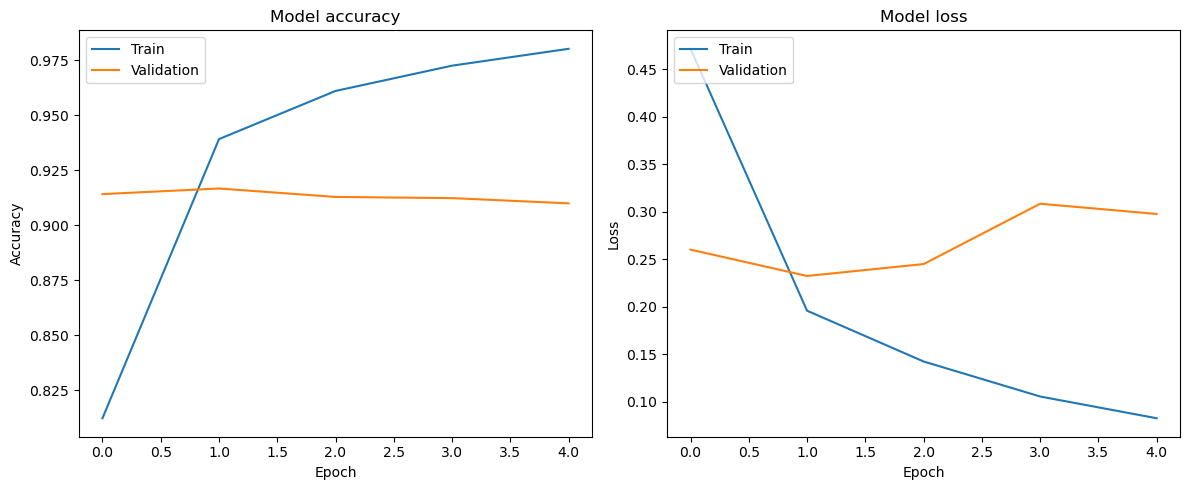

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

    We can also perform cross fold validation to assess model performance before evaluating it on the test set.

In [55]:
def perform_kfold_validation(X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    
    for train_idx, test_idx in kfold.split(X, y):
        # Create and compile model
        model = lstm_model()
        
        # Train model
        model.fit(X[train_idx], y[train_idx], 
                  epochs=10, 
                  batch_size=64, 
                  verbose=0)
        
        # Evaluate model
        scores = model.evaluate(X[test_idx], y[test_idx], verbose=0)
        print(f'Fold {fold_no}: Loss = {scores[0]:.4f}, Accuracy = {scores[1]:.4f}')
        
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])
        
        fold_no += 1
    
    # Print average scores
    print('\nAverage scores:')
    print(f'Loss: {np.mean(loss_per_fold):.4f}')
    print(f'Accuracy: {np.mean(acc_per_fold):.4f}')
    
    return np.mean(acc_per_fold), np.mean(loss_per_fold)

# Uncomment to run k-fold validation (may take some time)
kfold_acc, kfold_loss = perform_kfold_validation(X_final, y_final)

Fold 1: Loss = 0.4810, Accuracy = 0.8983
Fold 2: Loss = 0.4011, Accuracy = 0.9032
Fold 3: Loss = 0.4161, Accuracy = 0.9062
Fold 4: Loss = 0.3824, Accuracy = 0.9076
Fold 5: Loss = 0.4132, Accuracy = 0.9119

Average scores:
Loss: 0.4188
Accuracy: 0.9054
